# **Insurance Loss Analytics Project**

This notebook addresses the challenge of predicting insurance claim losses to support accurate and fair premium pricing. The analysis focuses on three core predictive tasks:

### **Project Objectives**

1. **Loss Cost per Exposure Unit (LC)**  
   Defined as: LC = X.15 / X.16

2. **Historically Adjusted Loss Cost (HALC)**  
   Defined as: HALC = LC × X.18

3. **Claim Status (CS)**  
   Binary classification of whether a claim was made (1) or not (0)

These targets exhibit strong right skew and zero-inflation, requiring specialized treatment during preprocessing and modeling.

---

### **Workflow Summary**

- **Data Loading**  
  Train and test datasets are loaded from Google Drive

- **Preprocessing**  
  Includes target variable creation, column renaming, and date parsing

- **Feature Engineering**  
  Constructs derived features such as:
  - Driver and vehicle risk scores
  - Customer loyalty index
  - Power-to-weight and premium-to-value ratios
  - Age and experience categories

- **Categorical Handling**  
  One-hot encoding applied to selected categorical features

- **Exploratory Data Analysis (EDA)**  
  - Distribution analysis of LC, HALC, and CS
  - Log-transformed skewness assessment
  - Correlation heatmaps with target variables
  - Boxplots and scatter plots for engineered features
  - Distributions of categorical and numeric variables

---

The resulting processed datasets are prepared for use in regression and classification modeling, with evaluation based on MSE (for LC and HALC) and ROC AUC (for CS).


# **Mounting Google Drive and Loading Imports**

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Main imports
import os
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
!pip install --upgrade xgboost --quiet
!pip install optuna

# Machine learning imports
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import (mean_squared_error, r2_score, mean_absolute_error,
                            confusion_matrix, roc_curve, auc, classification_report,
                            accuracy_score, precision_score, recall_score, f1_score)
from sklearn.linear_model import (LogisticRegression, Ridge, Lasso,
                                TweedieRegressor, HuberRegressor, GammaRegressor)
from sklearn.ensemble import (RandomForestRegressor, GradientBoostingRegressor,
                            RandomForestClassifier)
from sklearn.svm import SVR
from sklearn.dummy import DummyRegressor
from sklearn.feature_selection import RFE
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
from imblearn.over_sampling import SMOTE
import xgboost as xgb
from lightgbm import LGBMRegressor
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from xgboost import XGBRegressor
from xgboost.callback import EarlyStopping

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 253.9/253.9 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 24.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 21.6 MB/s eta 0:00:00


# **Data Loading**

In [ ]:
# Load train and test data
test_raw= pd.read_csv('/content/drive/MyDrive/DSO530Public/Group Project/Data/insurance_test.csv')
train_raw = pd.read_csv('/content/drive/MyDrive/DSO530Public/Group Project/Data/insurance_train.csv')

# Display first 5 rows and info
print("Training data preview:")
display(train_raw.head())
display(train_raw.info())

print("\nTest data preview:")
display(test_raw.head())
display(test_raw.info())

Training data preview:


,X.1,X.2,X.3,X.4,X.5,X.6,X.7,X.8,X.9,X.10,...,X.19,X.20,X.21,X.22,X.23,X.24,X.25,X.26,X.27,X.28
0,34429,01/06/2017,01/06/2017,01/06/2018,29/08/1996,31/05/2016,0,1,1,1,...,3,0,0,1994,75,1360,12795.55,4,P,1040
1,5552,19/09/2016,19/09/2018,19/09/2019,30/04/1992,03/08/2010,0,3,1,1,...,3,0,0,2004,100,1896,15386.00,5,D,1165
2,47700,08/01/2003,08/01/2018,08/01/2019,23/03/1972,01/02/1998,1,20,2,2,...,3,0,0,2002,95,1390,16470.00,5,P,1235
3,25425,01/10/2015,01/10/2018,01/10/2019,05/03/1946,07/08/1964,0,8,2,3,...,3,0,0,2010,140,2497,27381.00,5,D,1984
4,4727,26/01/2017,26/01/2018,26/01/2019,25/04/1973,24/07/1998,0,9,1,1,...,3,0,0,1998,80,1969,36600.00,3,P,1702


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37451 entries, 0 to 37450
Data columns (total 28 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   X.1     37451 non-null  int64  
 1   X.2     37451 non-null  object 
 2   X.3     37451 non-null  object 
 3   X.4     37451 non-null  object 
 4   X.5     37451 non-null  object 
 5   X.6     37451 non-null  object 
 6   X.7     37451 non-null  int64  
 7   X.8     37451 non-null  int64  
 8   X.9     37451 non-null  int64  
 9   X.10    37451 non-null  int64  
 10  X.11    37451 non-null  int64  
 11  X.12    37451 non-null  int64  
 12  X.13    37451 non-null  int64  
 13  X.14    37451 non-null  float64
 14  X.15    37451 non-null  float64
 15  X.16    37451 non-null  int64  
 16  X.17    37451 non-null  int64  
 17  X.18    37451 non-null  float64
 18  X.19    37451 non-null  int64  
 19  X.20    37451 non-null  int64  
 20  X.21    37451 non-null  int64  
 21  X.22    37451 non-null  int64  
 22

None


Test data preview:


,X.2,X.3,X.4,X.5,X.6,X.7,X.8,X.9,X.10,X.11,...,X.19,X.20,X.21,X.22,X.23,X.24,X.25,X.26,X.27,X.28
0,23/06/2017,23/06/2018,23/06/2019,13/09/1982,03/02/2011,0,2,2,2,1,...,3,1,0,2003,115,1910,16400.00,5,D,1305
1,29/06/2015,29/06/2016,29/06/2017,07/07/1946,12/08/1966,0,2,1,1,1,...,3,0,0,1999,90,1597,13480.70,5,P,1083
2,14/03/2018,14/03/2018,14/03/2019,26/12/1957,02/09/1977,0,1,4,4,2,...,3,0,0,2003,143,2148,36500.00,5,D,1495
3,16/10/2014,16/10/2018,16/10/2019,27/02/1961,29/10/1980,1,5,1,1,1,...,2,1,0,1998,60,1686,12356.81,5,D,1010
4,01/07/2015,01/07/2017,01/07/2018,03/07/1986,02/08/2006,0,3,1,1,1,...,3,0,0,2015,66,998,11800.00,5,P,933


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15787 entries, 0 to 15786
Data columns (total 23 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   X.2     15787 non-null  object 
 1   X.3     15787 non-null  object 
 2   X.4     15787 non-null  object 
 3   X.5     15787 non-null  object 
 4   X.6     15787 non-null  object 
 5   X.7     15787 non-null  int64  
 6   X.8     15787 non-null  int64  
 7   X.9     15787 non-null  int64  
 8   X.10    15787 non-null  int64  
 9   X.11    15787 non-null  int64  
 10  X.12    15787 non-null  int64  
 11  X.13    15787 non-null  int64  
 12  X.14    15787 non-null  float64
 13  X.19    15787 non-null  int64  
 14  X.20    15787 non-null  int64  
 15  X.21    15787 non-null  int64  
 16  X.22    15787 non-null  int64  
 17  X.23    15787 non-null  int64  
 18  X.24    15787 non-null  int64  
 19  X.25    15787 non-null  float64
 20  X.26    15787 non-null  int64  
 21  X.27    15787 non-null  object 
 22

None

# **Data Preprocessing**

In [ ]:
import pandas as pd
import numpy as np

train = train_raw.copy()
test = test_raw.copy()

# -------------------------------------------
# 1. TARGET VARIABLE CREATION
# -------------------------------------------
train['LC'] = np.where(train['X.16'] > 0, train['X.15'] / train['X.16'], 0)
train['CS'] = (train['X.16'] > 0).astype(int)
train['HALC'] = train['LC'] * train['X.18']

# -------------------------------------------
# 2. CLEANING & RENAME COLUMNS
# -------------------------------------------
leak_cols = ['X.1', 'X.15', 'X.16', 'X.17', 'X.18']
train.drop(columns=leak_cols, inplace=True, errors='ignore')

column_mapping = {
    'X.1': 'policy_id', 'X.2': 'policy_start_date', 'X.3': 'last_renewal_date', 'X.4': 'next_renewal_date',
    'X.5': 'birth_date', 'X.6': 'license_issue_date', 'X.7': 'contract_channel', 'X.8': 'years_with_company',
    'X.9': 'total_policies', 'X.10': 'max_policies_held', 'X.11': 'max_products_held',
    'X.12': 'cancelled_policies_current_year', 'X.13': 'payment_method', 'X.14': 'net_premium',
    'X.19': 'vehicle_risk_type', 'X.20': 'region_type', 'X.21': 'multiple_drivers',
    'X.22': 'vehicle_registration_year', 'X.23': 'vehicle_power_hp', 'X.24': 'vehicle_cylinder_capacity',
    'X.25': 'vehicle_market_value', 'X.26': 'num_vehicle_doors', 'X.27': 'energy_source', 'X.28': 'vehicle_weight_kg'
}

train.rename(columns=column_mapping, inplace=True)
test.rename(columns=column_mapping, inplace=True)

# -------------------------------------------
# 3. DATE PARSING
# -------------------------------------------
date_cols = ['policy_start_date', 'last_renewal_date', 'next_renewal_date', 'birth_date', 'license_issue_date']
for col in date_cols:
    train[col] = pd.to_datetime(train[col], dayfirst=True, errors='coerce')
    test[col] = pd.to_datetime(test[col], dayfirst=True, errors='coerce')

# -------------------------------------------
# 4. FEATURE ENGINEERING
# -------------------------------------------
def engineer_features(df):
    # Basic date-based features
    df['driver_age_at_policy_start'] = (df['policy_start_date'] - df['birth_date']).dt.days // 365
    df['driving_experience'] = ((df['policy_start_date'] - df['license_issue_date']).dt.days // 365).clip(lower=0)

    df['vehicle_age'] = df['policy_start_date'].dt.year - df['vehicle_registration_year']
    df['policy_duration'] = (df['next_renewal_date'] - df['policy_start_date']).dt.days // 365

    # Create age categories
    df['driver_age_cat'] = pd.cut(
        df['driver_age_at_policy_start'],
        bins=[0, 25, 35, 45, 55, 65, 100],
        labels=['<25', '25-35', '35-45', '45-55', '55-65', '65+']
    )

    # Vehicle age categories
    df['vehicle_age_cat'] = pd.cut(
    df['vehicle_age'],
    bins=[-1, 5, 12, 100],
    labels=['New-Moderate', 'Mature', 'Old']
    )

    # Driving experience categories
    df['driving_exp_cat'] = pd.cut(
    df['driving_experience'],
    bins=[0, 2, 10, 100],
    labels=['Novice', 'Intermediate', 'Experienced']
    )

    # Risk scoring
    df['driver_risk_score'] = (
        (df['driver_age_at_policy_start'] < 25).astype(int) * 3 +  # Young drivers risk
        (df['driving_experience'] < 2).astype(int) * 4 +     # New drivers risk
        (df['cancelled_policies_current_year'] > 0).astype(int) * 2  # Prior cancellations risk
    )

    # Vehicle risk score - no percentile reference to ensure consistency
    df['vehicle_risk_score'] = (
        (df['vehicle_power_hp'] > 150).astype(int) * 3 +  # High power
        (df['vehicle_age'] > 15).astype(int) * 2 +        # Very old vehicles
        (df['vehicle_age'] < 2).astype(int) * 1           # Very new vehicles
    )

    # Interaction features
    df['young_driver_high_power'] = (
        (df['driver_age_at_policy_start'] < 25).astype(int) *
        (df['vehicle_power_hp'] > 150).astype(int)
    )

    df['new_license_high_power'] = (
        (df['driving_experience'] < 2).astype(int) *
        (df['vehicle_power_hp'] > 150).astype(int)
    )

    # Power-to-weight ratio (performance indicator)
    df['power_weight_ratio'] = df['vehicle_power_hp'] / df['vehicle_weight_kg']

    # Premium to vehicle value ratio
    df['premium_to_value_ratio'] = df['net_premium'] / df['vehicle_market_value']

    # Customer loyalty score (weighted combination)
    w1, w2, w3, w4 = 0.4, 0.3, 0.2, 0.1  # Weights based on importance
    df['customer_loyalty_score'] = (
        w1 * df['years_with_company'] +
        w2 * df['total_policies'] +
        w3 * df['max_policies_held'] +
        w4 * df['max_products_held']
    )

    # Payment reliability indicator
    df['payment_reliability'] = (
        1 - (df['cancelled_policies_current_year'] > 0).astype(int) * 0.5 -
        (df['payment_method'] > 0).astype(int) * 0.2
    )

    # Create non-continuation flag (for policies that don't continue)
    reference_date = pd.to_datetime('2019-12-31')  # Assuming this is a reasonable reference date
    df['non_continuation_flag'] = (df['next_renewal_date'] < reference_date).astype(int)

    # Young driver flag
    df['young_driver'] = (df['driver_age_at_policy_start'] < 25).astype(int)

    # Age at license issue
    df['age_at_license'] = (df['license_issue_date'] - df['birth_date']).dt.days / 365

    # Vehicle power categories
    df['power_cat'] = pd.cut(
        df['vehicle_power_hp'],
        bins=[0, 75, 125, 200, 1000],
        labels=['Economy', 'Standard', 'High', 'Premium']
    )

    return df

train = engineer_features(train)
test = engineer_features(test)

# -------------------------------------------
# 5. DROP RAW DATE COLUMNS
# -------------------------------------------
train.drop(columns=date_cols, inplace=True)
test.drop(columns=date_cols, inplace=True)

# -------------------------------------------
# 6. HANDLE CATEGORICALS
# -------------------------------------------
# Handle energy_source - fill NA with O and one-hot encode
train['energy_source'] = train['energy_source'].fillna('O')
test['energy_source'] = test['energy_source'].fillna('O')

cat_cols = ['vehicle_risk_type', 'energy_source', 'driver_age_cat',
            'vehicle_age_cat', 'driving_exp_cat', 'power_cat']

# -------------------------------------------
# 7. ONE-HOT ENCODING
# -------------------------------------------
train_encoded = pd.get_dummies(train, columns=cat_cols, drop_first=True)
test_encoded = pd.get_dummies(test, columns=cat_cols, drop_first=True)

# Cast all features to float64 for model compatibility (esp. for statsmodels)
train_encoded = train_encoded.astype(float)
test_encoded = test_encoded.astype(float)


# -------------------------------------------
# 8. DROP REDUNDANT/LOW-SIGNAL FEATURES
# -------------------------------------------
drop_cols = ['vehicle_registration_year']
train_encoded.drop(columns=drop_cols, inplace=True, errors='ignore')
test_encoded.drop(columns=drop_cols, inplace=True, errors='ignore')


# -------------------------------------------
# 9. ALIGN TEST TO TRAIN
# -------------------------------------------
train_columns = train_encoded.columns
test_columns = test_encoded.columns

# Find columns in train but not in test
missing_cols = set(train_columns) - set(test_columns)
for col in missing_cols:
    test_encoded[col] = 0  # Add missing columns to test

# Find columns in test but not in train (and drop them)
extra_cols = set(test_columns) - set(train_columns)
test_encoded.drop(columns=extra_cols, inplace=True, errors='ignore')

# Ensure columns are in the same order
test_encoded = test_encoded[train_encoded.columns]

In [ ]:
train_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37451 entries, 0 to 37450
Data columns (total 50 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   contract_channel                 37451 non-null  float64
 1   years_with_company               37451 non-null  float64
 2   total_policies                   37451 non-null  float64
 3   max_policies_held                37451 non-null  float64
 4   max_products_held                37451 non-null  float64
 5   cancelled_policies_current_year  37451 non-null  float64
 6   payment_method                   37451 non-null  float64
 7   net_premium                      37451 non-null  float64
 8   region_type                      37451 non-null  float64
 9   multiple_drivers                 37451 non-null  float64
 10  vehicle_power_hp                 37451 non-null  float64
 11  vehicle_cylinder_capacity        37451 non-null  float64
 12  vehicle_market_val

In [ ]:
# # Create the directory if it doesn't exist
# output_dir = "/content/drive/MyDrive/DSO 530 Group Project"
# os.makedirs(output_dir, exist_ok=True)

# # Save the dataframes to CSV files
# train_encoded.to_csv(os.path.join(output_dir, "final_data_train.csv"), index=False)
# test_encoded.to_csv(os.path.join(output_dir, "final_data_test.csv"), index=False)


# **EDA**

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set default aesthetics
sns.set(style="whitegrid", palette="muted")
plt.rcParams['figure.figsize'] = (10, 6)


### **Target Variable Distributions**

This section visualizes the distribution of the two regression targets: **Loss Cost (LC)** and **Historically Adjusted Loss Cost (HALC)**.

- Both variables are highly right-skewed and contain a large number of zeros.
- Log-transformations are applied (using `log1p`) to assess whether the skew can be reduced and improve model interpretability.


Skewness of LC: 85.01951481664166
Skewness of HALC: 86.20252887281428


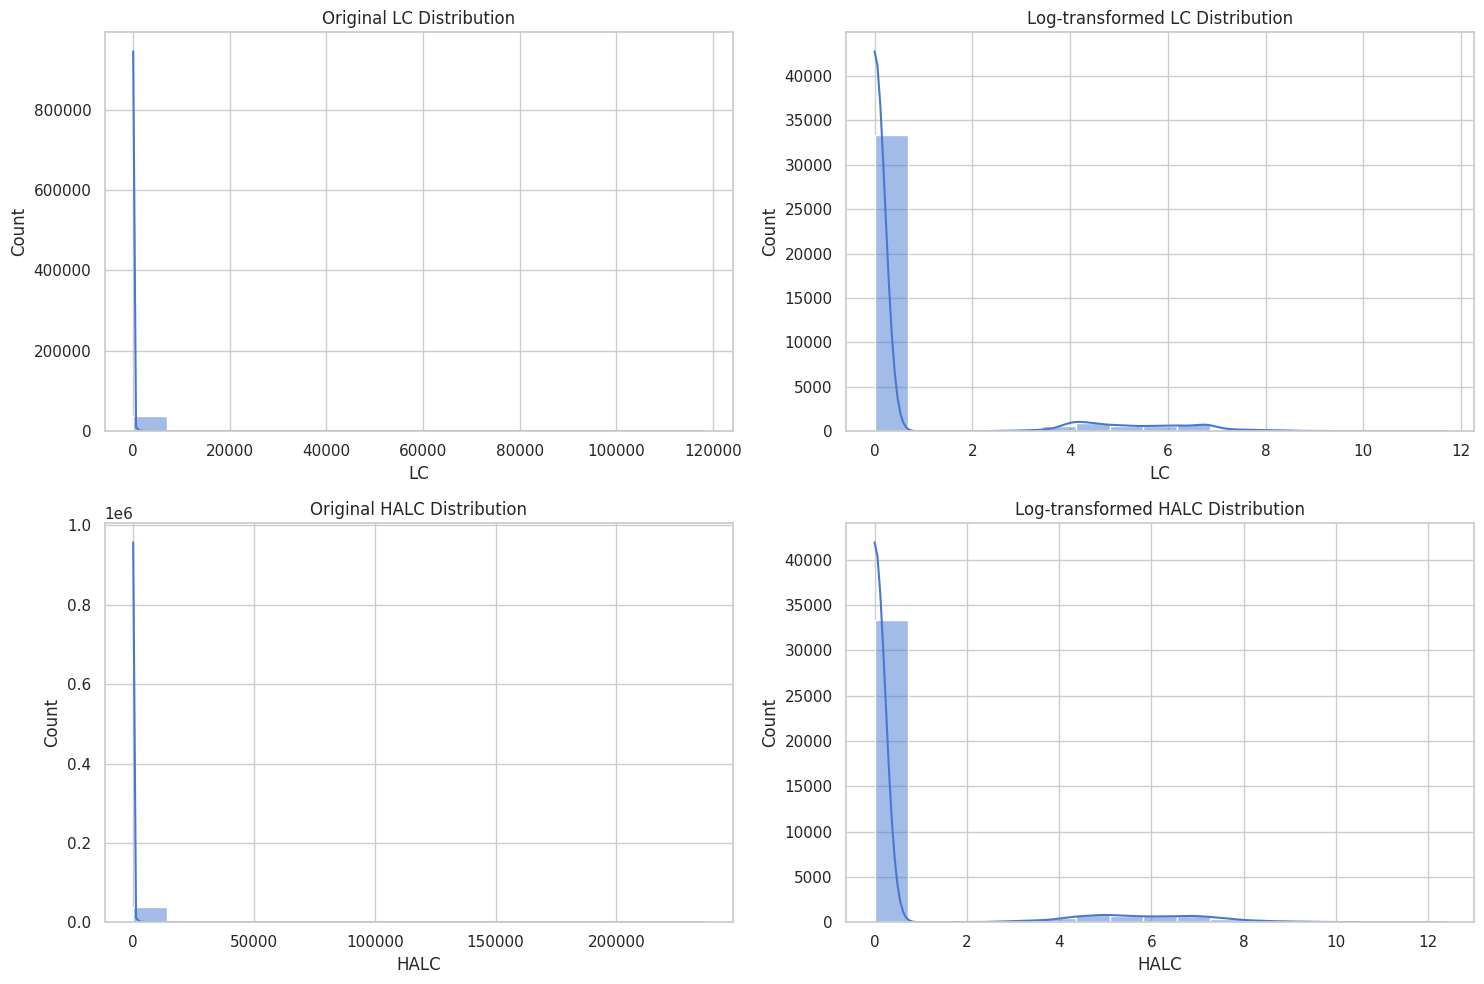

In [ ]:
# Calculate skewness for LC and HALC
from scipy.stats import skew

print("Skewness of LC:", skew(train['LC'].dropna()))
print("Skewness of HALC:", skew(train['HALC'].dropna()))

# Visualize log-transformed versions to see if that helps with skewness
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Original LC
sns.histplot(train['LC'].dropna(), ax=axes[0, 0], kde=True)
axes[0, 0].set_title('Original LC Distribution')

# Log-transformed LC (adding 1 to handle zeros)
sns.histplot(np.log1p(train['LC'].dropna()), ax=axes[0, 1], kde=True)
axes[0, 1].set_title('Log-transformed LC Distribution')

# Original HALC
sns.histplot(train['HALC'].dropna(), ax=axes[1, 0], kde=True)
axes[1, 0].set_title('Original HALC Distribution')

# Log-transformed HALC (adding 1 to handle zeros)
sns.histplot(np.log1p(train['HALC'].dropna()), ax=axes[1, 1], kde=True)
axes[1, 1].set_title('Log-transformed HALC Distribution')

plt.tight_layout()
plt.show()

### **Claim Status (CS) Distribution**

This plot shows the class balance for the binary classification task.

- The dataset is imbalanced, with the majority of policyholders not filing any claims (CS = 0).
- Class imbalance may require techniques such as SMOTE or adjusted thresholds during modeling.



Claim Status distribution:
CS
0    33300
1     4151
Name: count, dtype: int64
Claim Rate: 11.08%


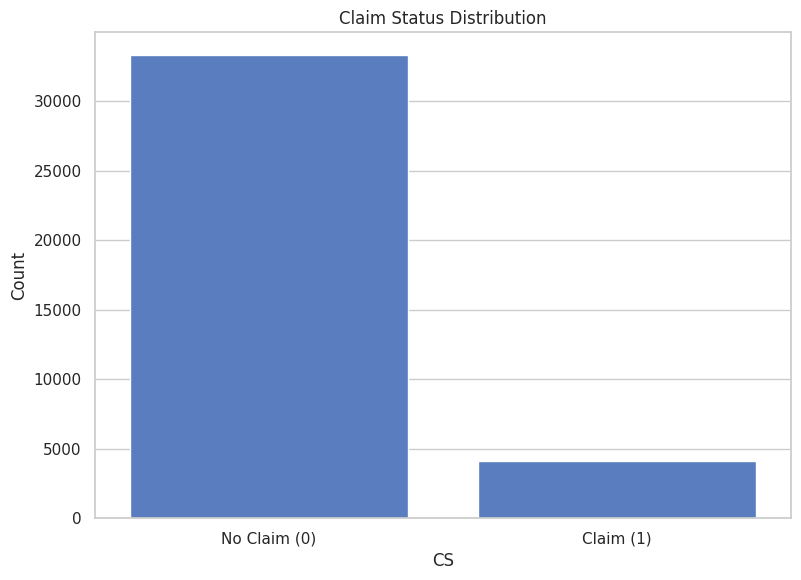

In [ ]:
# Get class distribution for Claim Status
cs_counts = train['CS'].value_counts()
print("\nClaim Status distribution:")
print(cs_counts)
print("Claim Rate: {:.2f}%".format(100 * cs_counts[1] / len(train)))

# Visualize class distribution
plt.figure(figsize=(8, 6))
sns.countplot(x='CS', data=train)
plt.title('Claim Status Distribution')
plt.ylabel('Count')
plt.xticks([0, 1], ['No Claim (0)', 'Claim (1)'])
plt.show()

### **Correlation Heatmaps with Target Variables**

These heatmaps show the top 10 features most correlated (by absolute Pearson correlation) with each target variable:

- **Loss Cost (LC)** and **HALC** are derived from claim amount (X.15), claim count (X.16), and severity adjustment (X.18). Features directly tied to these, such as `net_premium` or `policy_duration`, may show artificially strong correlations and are excluded from interpretation.
- Focus is placed on engineered and behavioral features such as:
  - **Customer Loyalty Score**
  - **Vehicle Power and Weight**
  - **Risk Scores**
- **Claim Status (CS)** shows generally weak linear correlations, with mild associations to customer behavior and vehicle characteristics.

Only derived, non-leaky, and interpretable features are retained in this analysis.


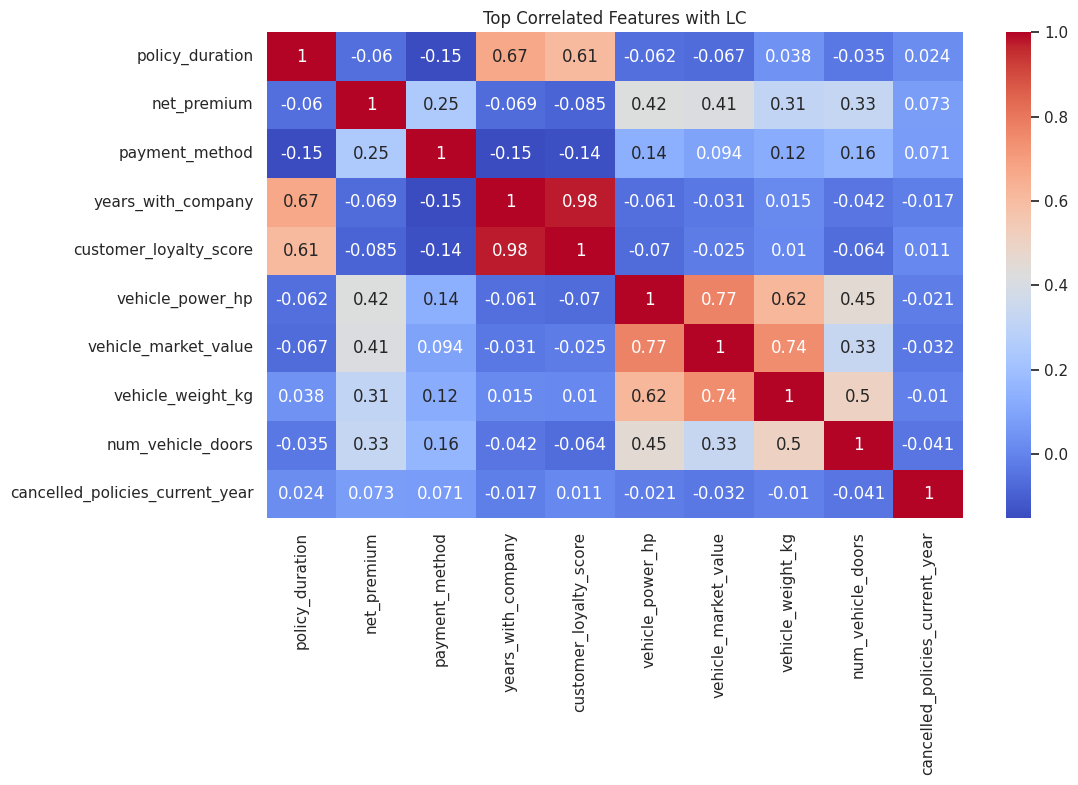

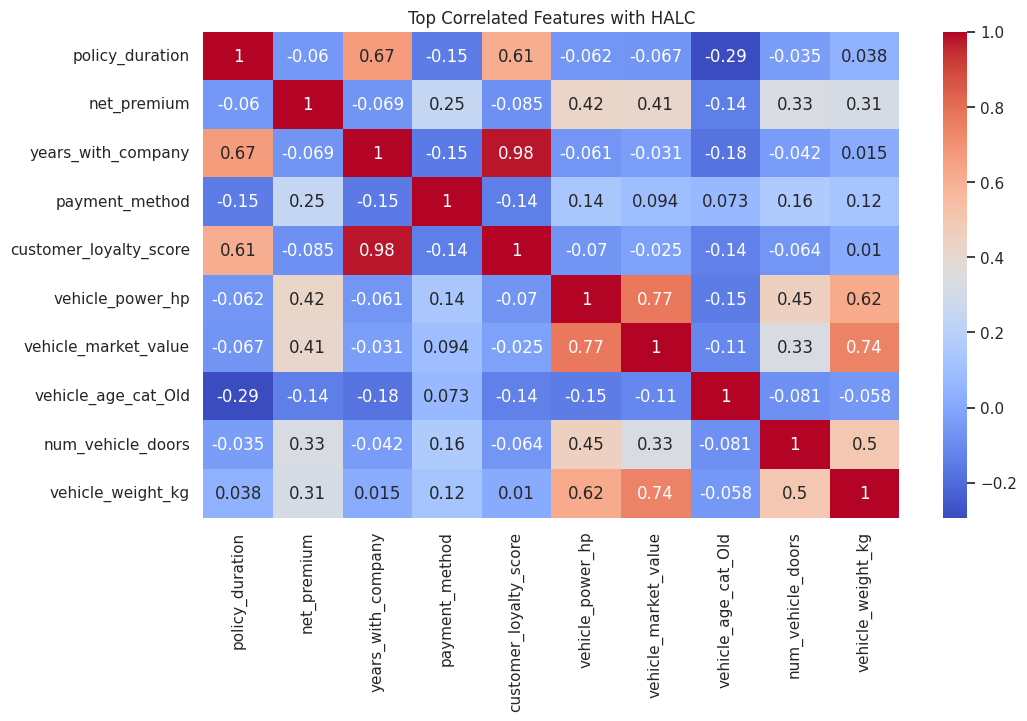

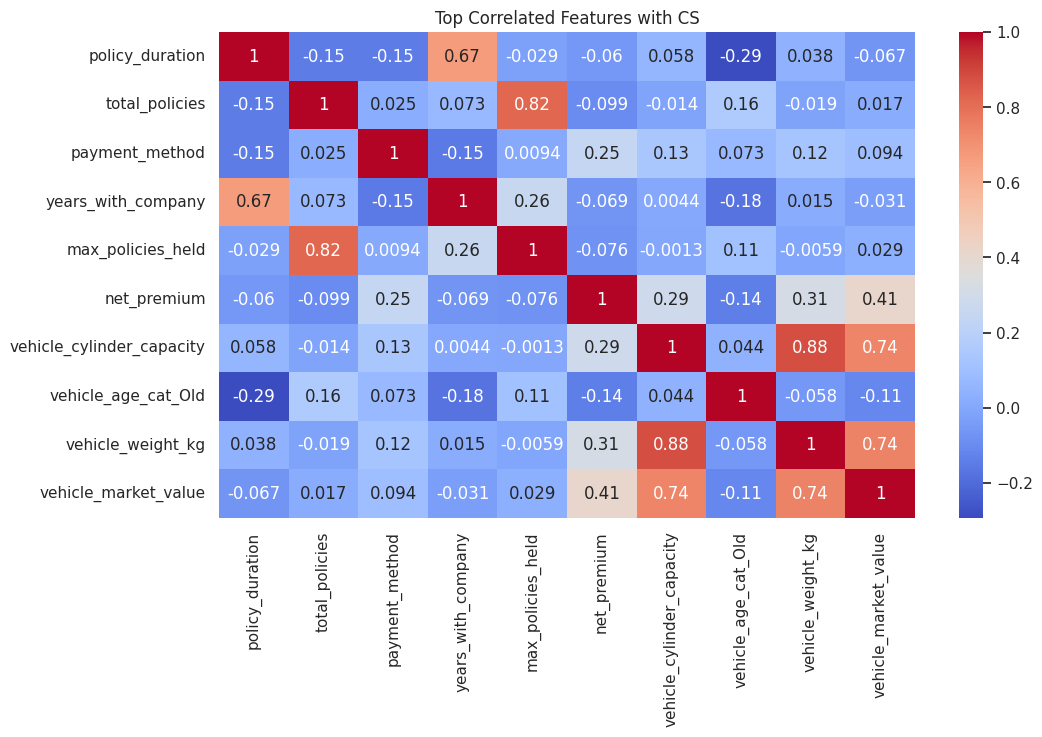

In [ ]:
# Correlation with LC (excluding targets)
exclude = ['LC', 'HALC', 'CS']
lc_corr = train_encoded.drop(columns=exclude).corrwith(train_encoded['LC']).abs()
top_corr_cols = lc_corr.sort_values(ascending=False).head(10).index.tolist()

# Heatmap
sns.heatmap(train_encoded[top_corr_cols].corr(), annot=True, cmap='coolwarm')
plt.title("Top Correlated Features with LC")
plt.show()

# Drop targets from predictors
exclude = ['LC', 'HALC', 'CS']
features = train_encoded.drop(columns=exclude)

# HALC
halc_corr = features.corrwith(train_encoded['HALC']).abs().sort_values(ascending=False).head(10)
sns.heatmap(train_encoded[halc_corr.index].corr(), annot=True, cmap='coolwarm')
plt.title("Top Correlated Features with HALC")
plt.show()

# CS
cs_corr = features.corrwith(train_encoded['CS']).abs().sort_values(ascending=False).head(10)
sns.heatmap(train_encoded[cs_corr.index].corr(), annot=True, cmap='coolwarm')
plt.title("Top Correlated Features with CS")
plt.show()



### **Boxplots for Engineered Category Features**

This section examines how target variables vary across engineered categories:

- **Driver Age**, **Vehicle Age**, **Driving Experience**, and **Power Category** show clear stratification for LC, HALC, and CS.
- Younger drivers and novice experience groups tend to show higher variability in loss metrics.


In [ ]:
train.columns

Index(['contract_channel', 'years_with_company', 'total_policies',
       'max_policies_held', 'max_products_held',
       'cancelled_policies_current_year', 'payment_method', 'net_premium',
       'vehicle_risk_type', 'region_type', 'multiple_drivers',
       'vehicle_registration_year', 'vehicle_power_hp',
       'vehicle_cylinder_capacity', 'vehicle_market_value',
       'num_vehicle_doors', 'energy_source', 'vehicle_weight_kg', 'LC', 'CS',
       'HALC', 'driver_age_at_policy_start', 'driving_experience',
       'vehicle_age', 'policy_duration', 'driver_age_cat', 'vehicle_age_cat',
       'driving_exp_cat', 'driver_risk_score', 'vehicle_risk_score',
       'young_driver_high_power', 'new_license_high_power',
       'power_weight_ratio', 'premium_to_value_ratio',
       'customer_loyalty_score', 'payment_reliability',
       'non_continuation_flag', 'young_driver', 'age_at_license', 'power_cat'],
      dtype='object')

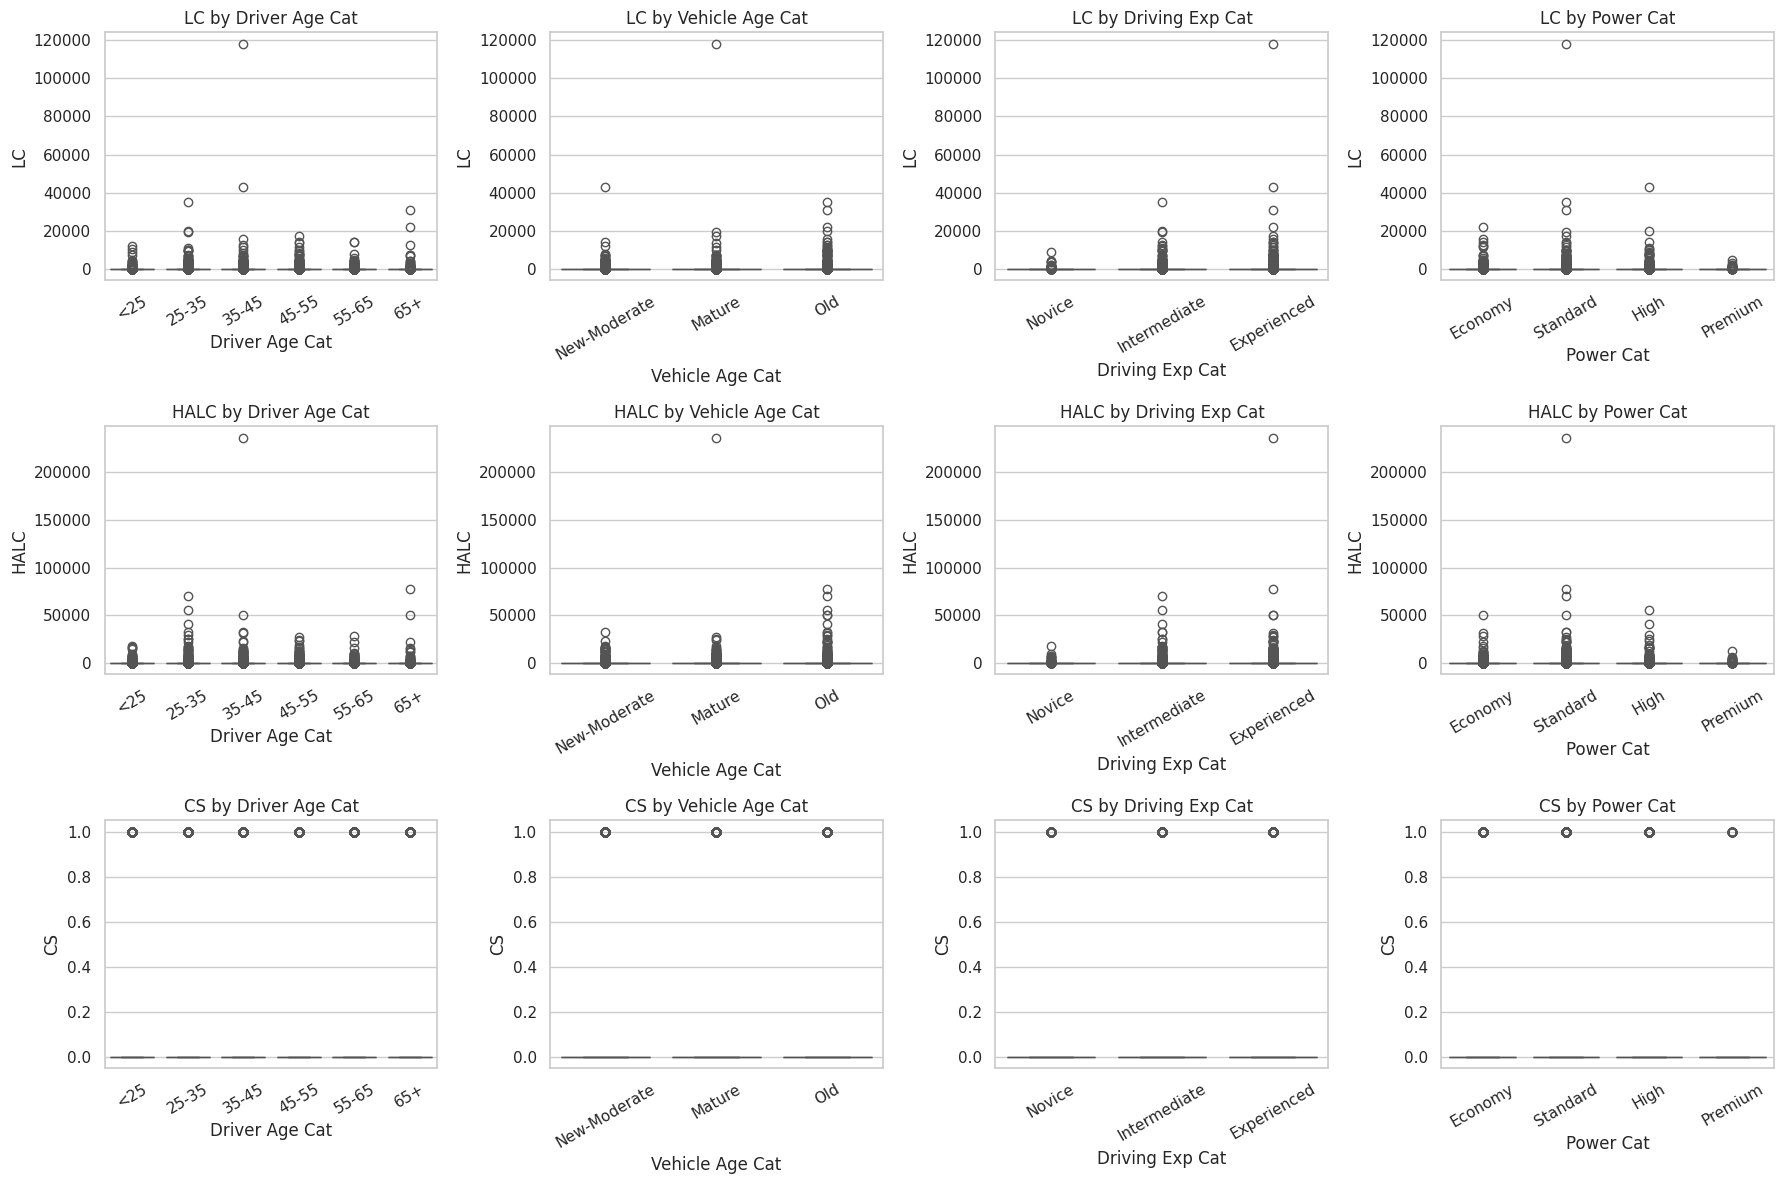

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Define the categorical features and titles
box_features = ['driver_age_cat', 'vehicle_age_cat', 'driving_exp_cat', 'power_cat']
y_vars = ['LC', 'HALC', 'CS']
titles = {
    'LC': 'LC',
    'HALC': 'HALC',
    'CS': 'CS'
}

# Set up the 3 (targets) x 4 (categories) subplot grid
fig, axes = plt.subplots(len(y_vars), len(box_features), figsize=(18, 12))
axes = axes.reshape(len(y_vars), len(box_features))

for i, y_var in enumerate(y_vars):
    for j, cat in enumerate(box_features):
        sns.boxplot(x=train[cat], y=train[y_var], ax=axes[i, j])
        axes[i, j].set_title(f"{titles[y_var]} by {cat.replace('_', ' ').title()}")
        axes[i, j].set_xlabel(cat.replace('_', ' ').title())
        axes[i, j].set_ylabel(titles[y_var])
        axes[i, j].tick_params(axis='x', rotation=30)

plt.tight_layout()
plt.show()


### **Risk Scores & Ratios vs LC, HALC, CS**

Scatterplots of key engineered risk metrics against each target variable:

- **Driver Risk Score**, **Vehicle Risk Score**, **Premium-to-Value Ratio**, and **Power-to-Weight Ratio** exhibit nonlinear relationships with LC, HALC, and CS.
- These features capture business-relevant interactions (e.g., high-powered cars driven by young or inexperienced users).


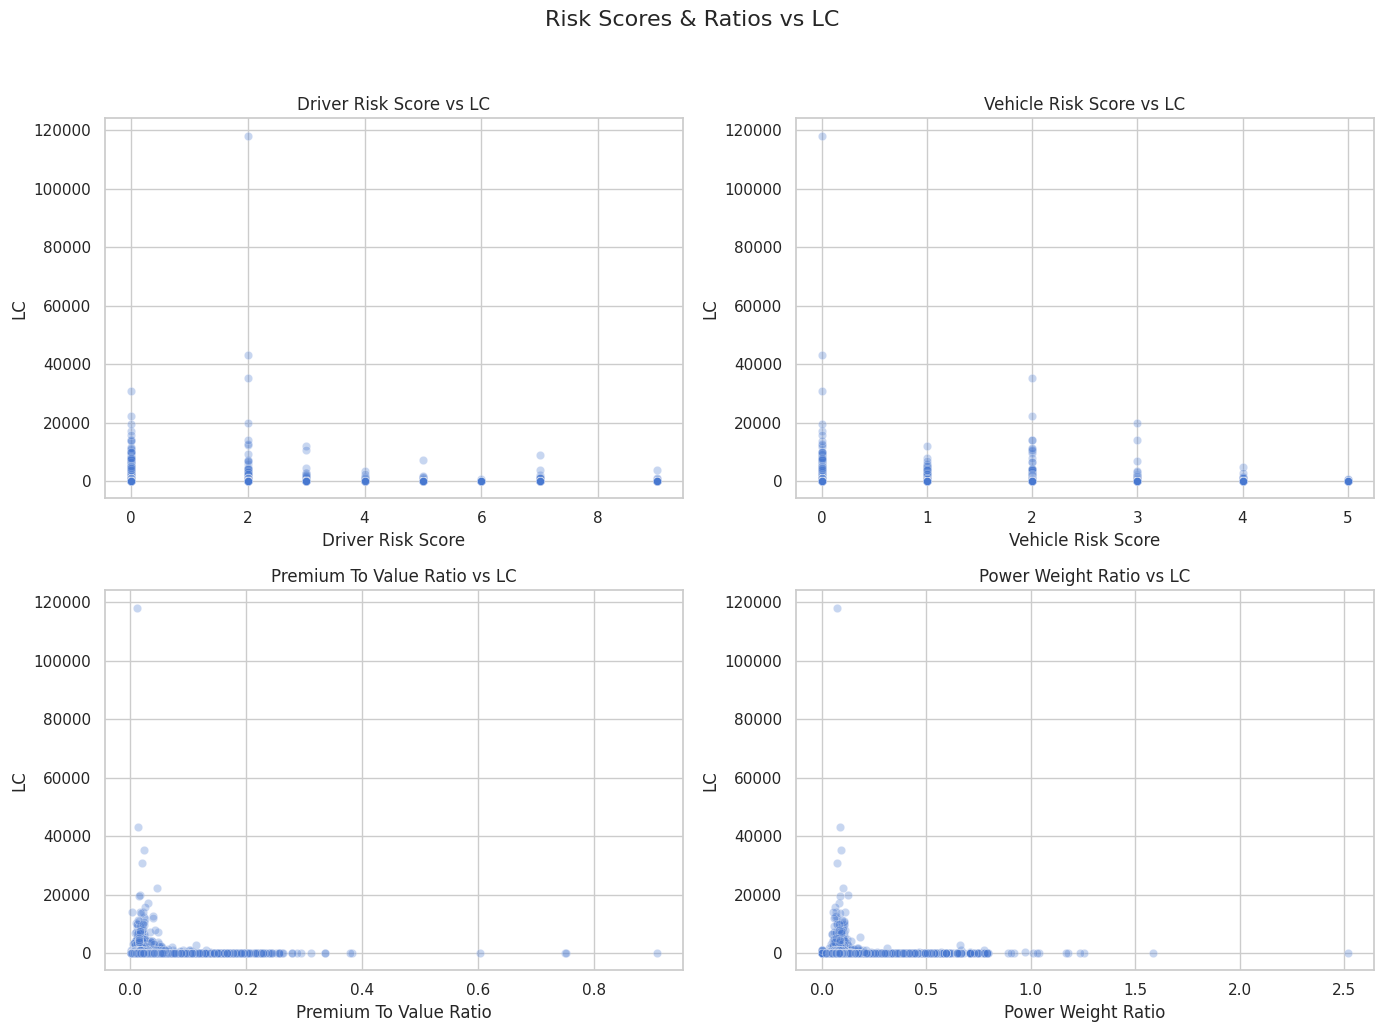

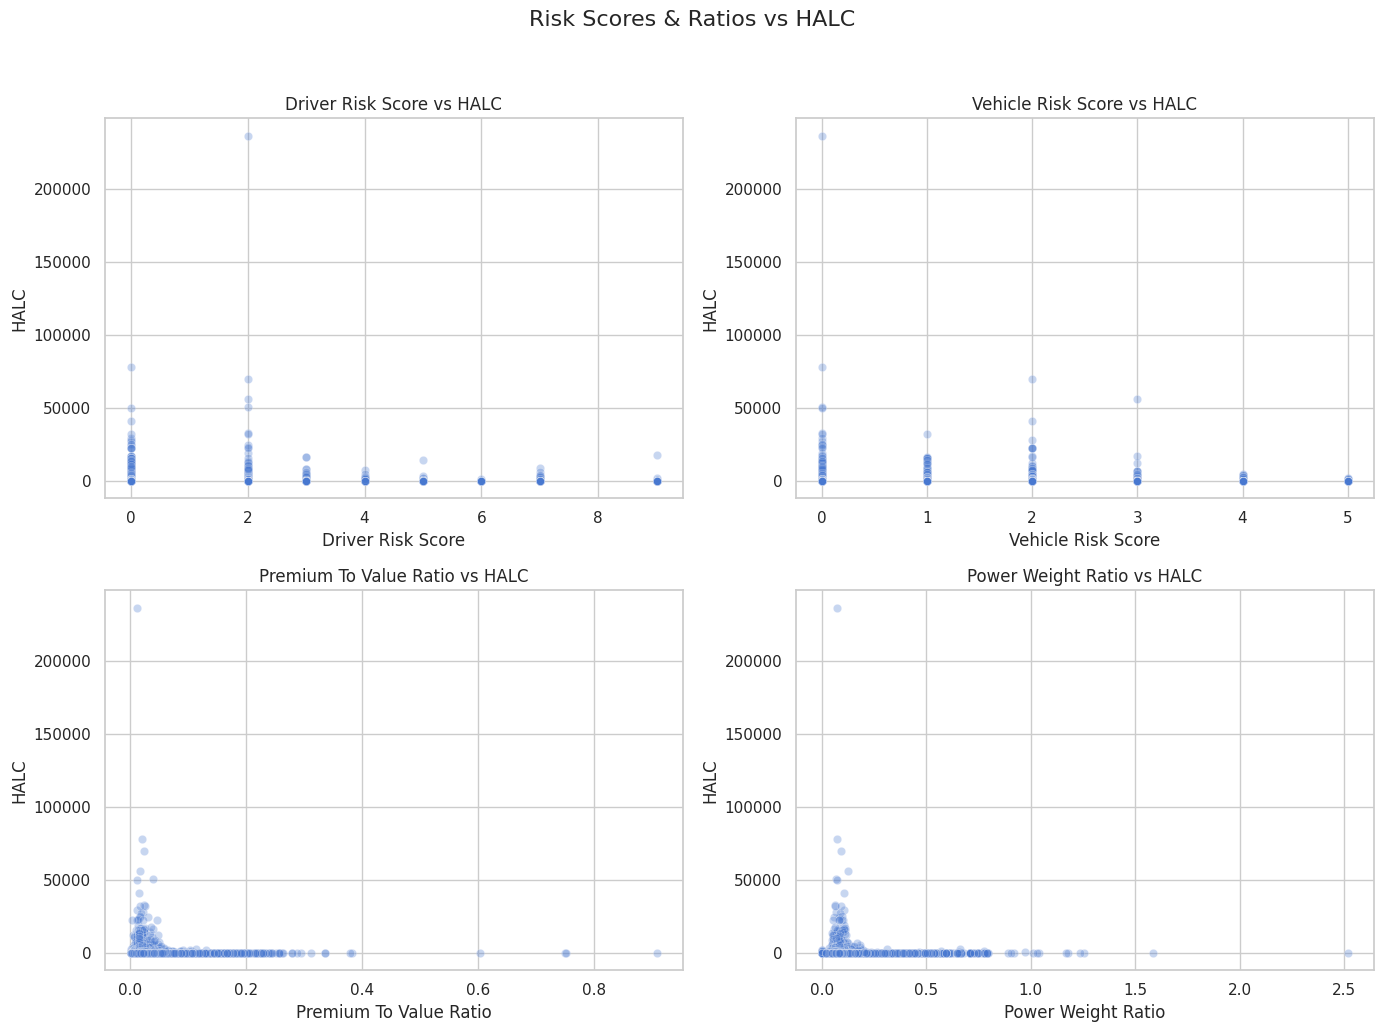

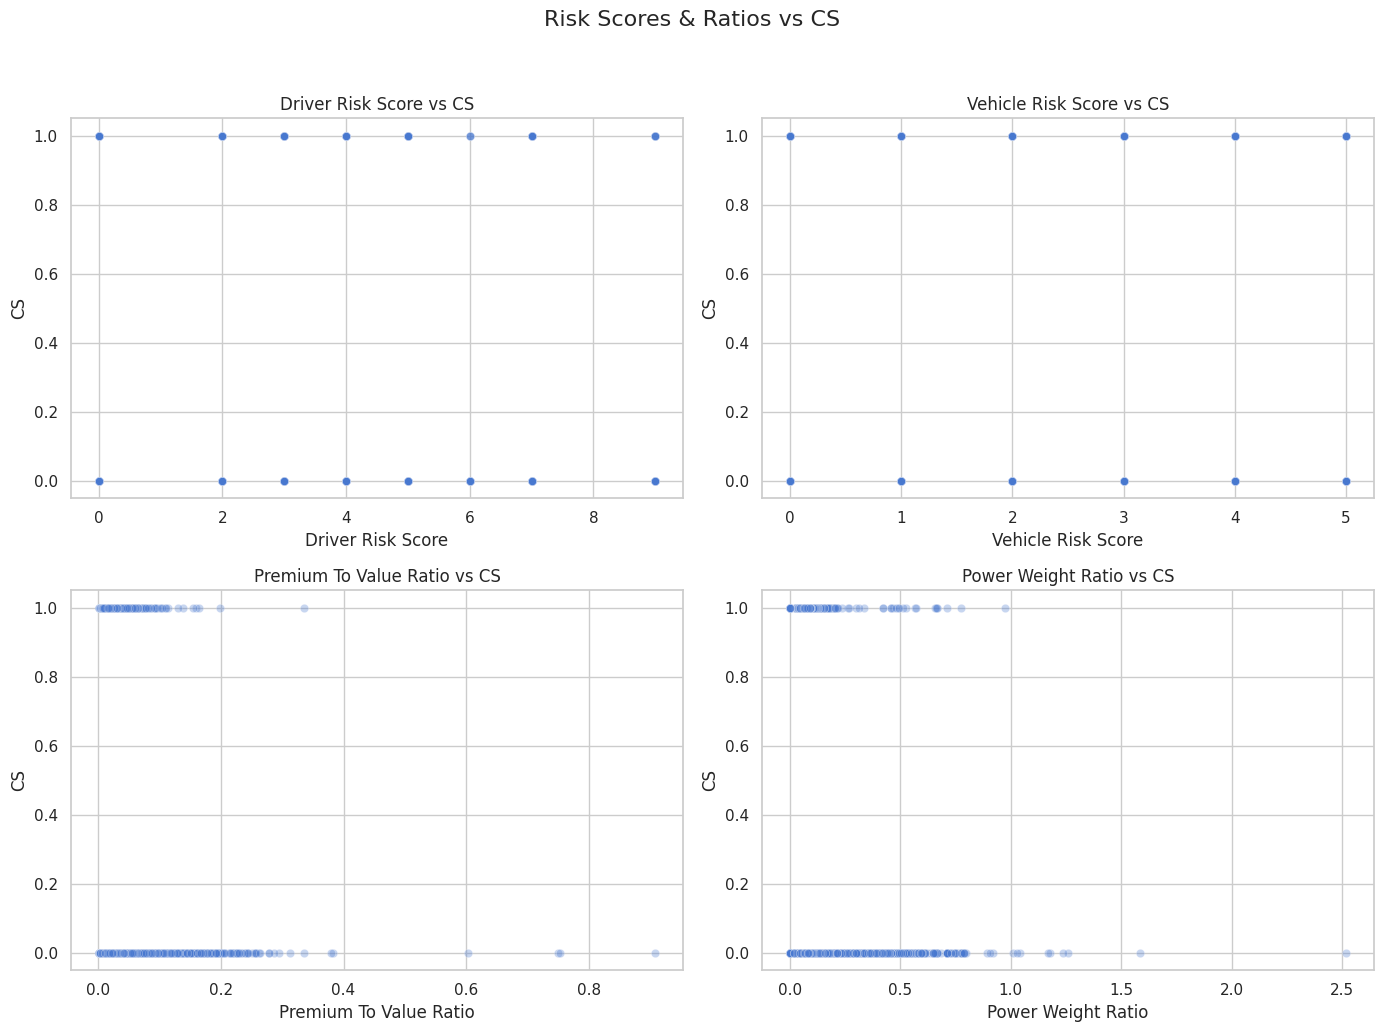

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

risk_feats = ['driver_risk_score', 'vehicle_risk_score', 'premium_to_value_ratio', 'power_weight_ratio']
targets = ['LC', 'HALC', 'CS']

for target in targets:
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    axes = axes.flatten()
    for i, feat in enumerate(risk_feats):
        sns.scatterplot(x=train_encoded[feat], y=train_encoded[target], alpha=0.3, ax=axes[i])
        axes[i].set_title(f"{feat.replace('_', ' ').title()} vs {target}")
        axes[i].set_xlabel(feat.replace('_', ' ').title())
        axes[i].set_ylabel(target)
    plt.suptitle(f"Risk Scores & Ratios vs {target}", fontsize=16, y=1.03)
    plt.tight_layout()
    plt.show()


### **Numerical Feature Distributions**

This section visualizes the distribution of all numeric features in the dataset.

- Many variables are right-skewed or zero-inflated, especially features like `net_premium`, `claim-related variables`, and `engineered ratios`.
- Variables such as `driving_experience`, `vehicle_age`, and `loyalty_score` show multimodal or long-tailed behavior.
- These patterns inform potential transformations, binning strategies, or scaling considerations during modeling.

Features directly derived from claim amounts (e.g., `LC`, `HALC`) are included for reference.


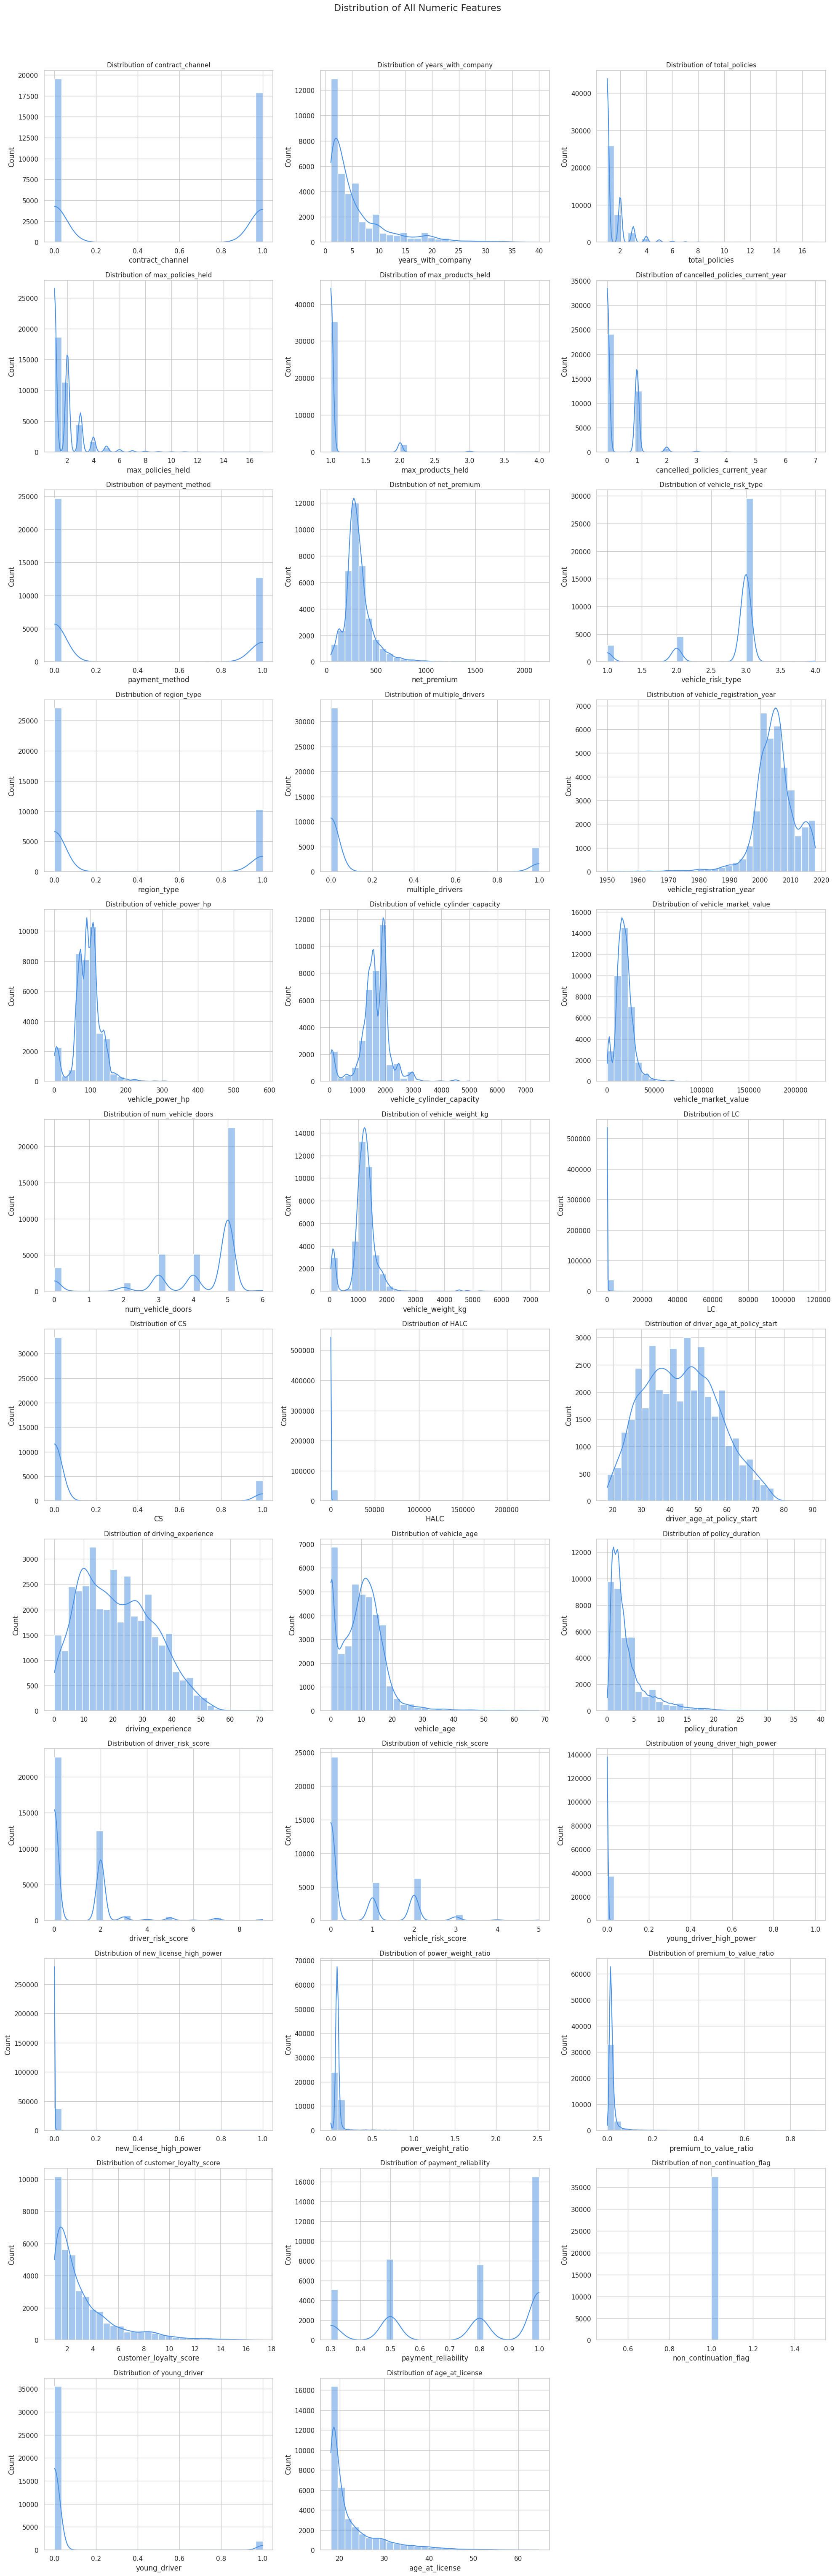

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Apply consistent styling
sns.set_theme(style="whitegrid")

# Get numeric columns
numeric_cols = train.select_dtypes(include=[np.number]).columns.tolist()

# Set up large plot grid
plt.figure(figsize=(20, 60))
for i, col in enumerate(numeric_cols):
    plt.subplot(len(numeric_cols) // 3 + 1, 3, i + 1)
    sns.histplot(train[col], bins=30, kde=True, color='#4A90E2')  # Soft blue
    plt.title(f'Distribution of {col}', fontsize=11)
    plt.xlabel(col)
    plt.ylabel('Count')

plt.tight_layout()
plt.suptitle("Distribution of All Numeric Features", fontsize=16, y=1.02)
plt.show()


### **Categorical Feature Distributions**

This section shows the class frequencies of selected categorical variables before encoding.

- Binary indicators like `contract_channel`, `payment_method`, `multiple_drivers`, and `region_type` are moderately imbalanced.
- The `vehicle_risk_type` and `energy_source` variables display multi-class behavior and are good candidates for one-hot encoding.
- Understanding these distributions helps ensure proper feature encoding and prevents rare-category overfitting.

Missing values (e.g., in `energy_source`) were previously handled through imputation.


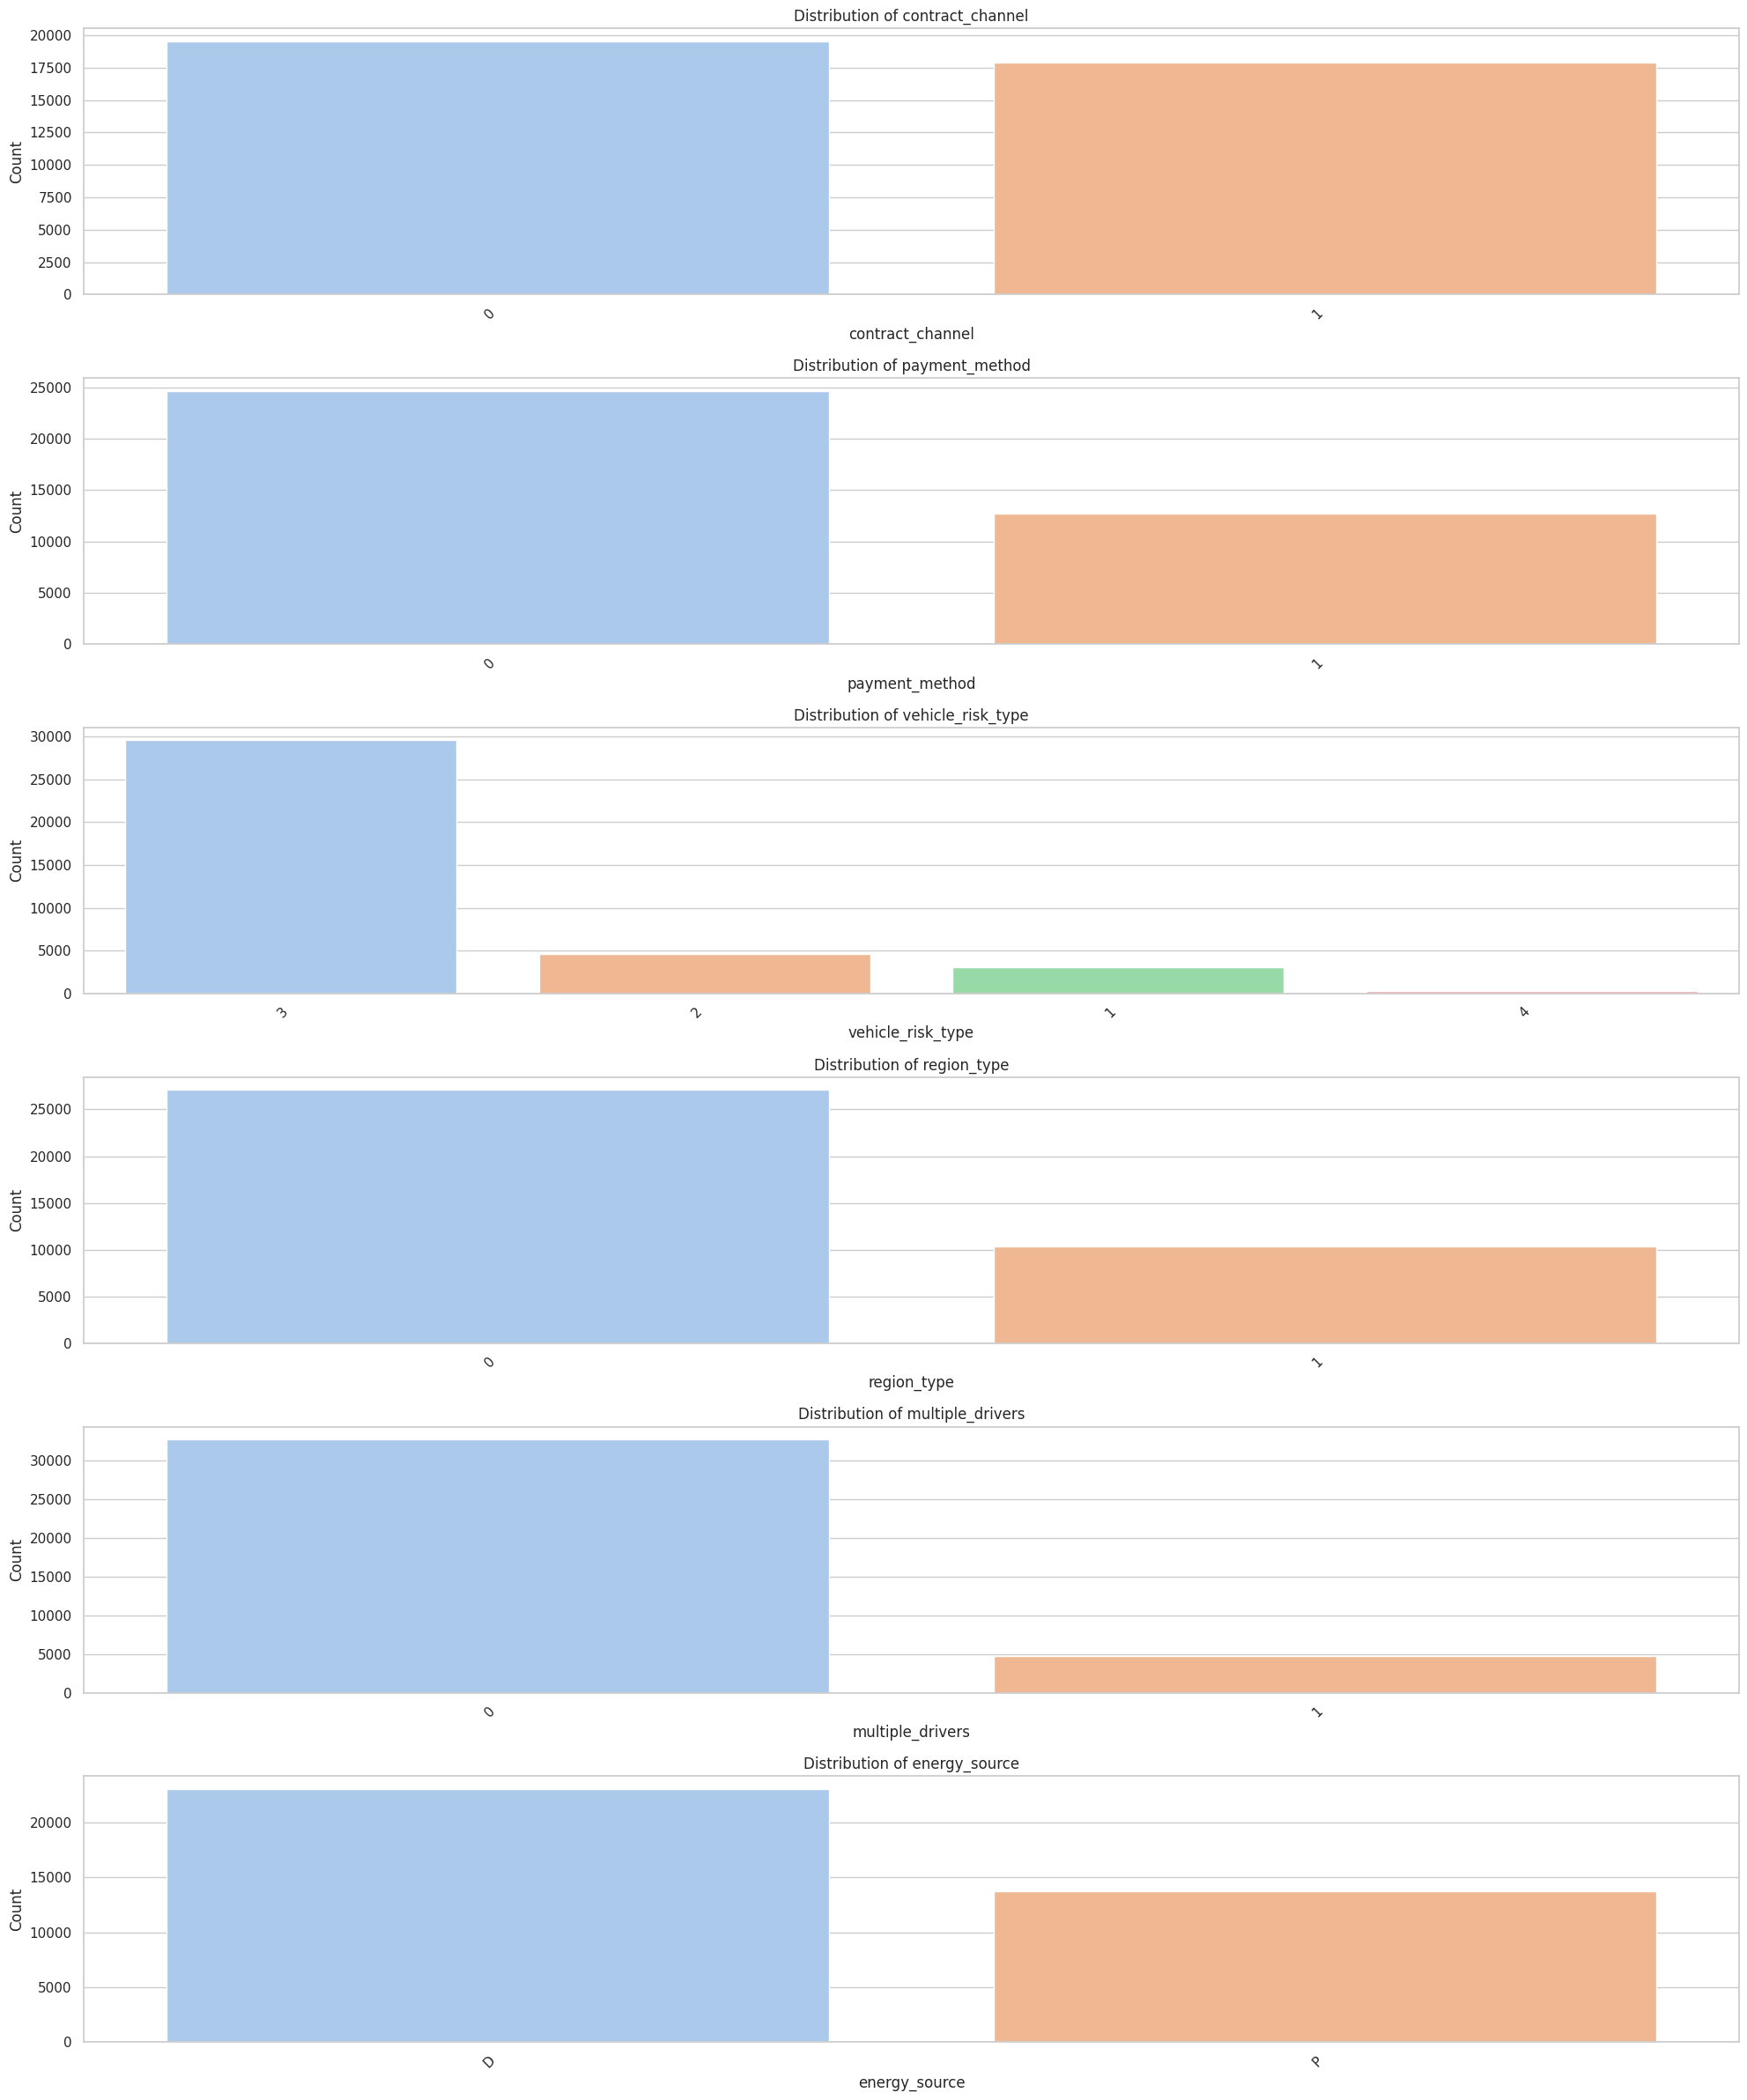

In [ ]:
# Barplots of All Categorical Features

import matplotlib.pyplot as plt
import seaborn as sns

train_raw = pd.read_csv('/content/drive/MyDrive/DSO530Public/Group Project/Data/insurance_train.csv')

# 1. Rename train_raw using existing mapping
column_mapping = {
    'X.1': 'policy_id', 'X.2': 'policy_start_date', 'X.3': 'last_renewal_date', 'X.4': 'next_renewal_date',
    'X.5': 'birth_date', 'X.6': 'license_issue_date', 'X.7': 'contract_channel', 'X.8': 'years_with_company',
    'X.9': 'total_policies', 'X.10': 'max_policies_held', 'X.11': 'max_products_held',
    'X.12': 'cancelled_policies_current_year', 'X.13': 'payment_method', 'X.14': 'net_premium',
    'X.19': 'vehicle_risk_type', 'X.20': 'region_type', 'X.21': 'multiple_drivers',
    'X.22': 'vehicle_registration_year', 'X.23': 'vehicle_power_hp', 'X.24': 'vehicle_cylinder_capacity',
    'X.25': 'vehicle_market_value', 'X.26': 'num_vehicle_doors', 'X.27': 'energy_source', 'X.28': 'vehicle_weight_kg'
}

train_raw_renamed = train_raw.rename(columns=column_mapping)

# 2. Define original categorical columns
cat_cols = ['contract_channel', 'payment_method', 'vehicle_risk_type',
            'region_type', 'multiple_drivers', 'energy_source']

# 3. Plot distributions
plt.figure(figsize=(20, len(cat_cols) * 4))
for i, col in enumerate(cat_cols):
    plt.subplot(len(cat_cols), 1, i + 1)
    sns.countplot(data=train_raw_renamed, x=col, palette='pastel', order=train_raw_renamed[col].value_counts().index)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()
